# Exploratory Data Analysis (EDA) for Social Sphere Project

## Project Overview

The **Social Sphere Project** aims to analyze social media usage patterns and their impact on mental health and sleep among different demographics. This notebook is dedicated to the Exploratory Data Analysis (EDA) phase, where we will gain insights into the dataset by examining the distributions and relationships among key variables. This analysis will help us understand the data better and prepare it for subsequent modeling phases.

## EDA Objectives

- **Profile Demographics**: Analyze age, gender, academic level, and country distributions.
- **Social-Media Behaviors**: Explore usage patterns and their relationships with mental health and sleep.
- **Target Variables**: Investigate patterns related to `Conflicts_Over_Social_Media` and `Addicted_Score`.
- **Cross-Country and Platform Analysis**: Assess differences across countries and platforms.
- **Data Preprocessing**: Handle missing values, encode categorical variables, detect outliers, and flag potential data biases.

## Structure

1. **Data Ingestion & Cleaning**: Load and clean the dataset, handle missing values, and prepare the data for analysis.
2. **Univariate Analysis**: Examine the distribution of individual variables.
3. **Bivariate/Multivariate Analysis**: Explore relationships between variables.
4. **Target-aware Exploration**: Analyze the distribution of target variables across demographics and behaviors.
5. **Bias & Outlier Detection**: Identify demographic skews and outliers.
6. **Pre-Clustering with PCA & UMAP**: Visualize naturally separated behavioral segments.

This EDA will provide a comprehensive understanding of the dataset, which is crucial for effective modeling and analysis in later stages.

# Libraries

In [83]:
# System & Data Handling
import os
import shutil
import pickle

# Data Loading
import kagglehub
import pandas as pd

# Plotting & Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import math

import numpy as np

# Constants
FIGSIZE = (16, 5)
FIGSIZE_LONG=(20, 6)
   

# Column Descriptions

- **Student_ID**: A unique integer identifier assigned to each survey respondent to enable de-duplication and track individual records without revealing personal information.  
- **Age**: The student’s age in completed years at the time of the survey, used to segment analysis by age group and control for developmental differences.  
- **Gender**: The student’s self-reported gender, recorded as “Male” or “Female” to allow for demographic breakdowns in usage and outcome measures.  
- **Academic_Level**: The highest level of education the respondent is currently enrolled in, with categories: “High School,” “Undergraduate,” or “Graduate,” facilitating stratified analyses by academic stage.  
- **Country**: The country of residence where the student completed the survey, enabling cross-country comparisons of social media behaviors and impacts.  
- **Avg_Daily_Usage_Hours**: The average number of hours per day the student spends on social media platforms, calculated from self-reported weekday and weekend usage estimates.  
- **Most_Used_Platform**: The social media platform on which the student spends the most time (e.g., Instagram, Facebook, TikTok), used to examine platform-specific effects.  
- **Affects_Academic_Performance**: A binary indicator (“Yes”/“No”) reflecting whether the student perceives their social media use as having a negative impact on their academic performance.  
- **Sleep_Hours_Per_Night**: The respondent’s average nightly sleep duration in hours, provided to investigate correlations between screen time and sleep quality/quantity.  
- **Mental_Health_Score**: A self-rated integer from 1 (poor) to 10 (excellent) indicating overall mental well-being, allowing assessment of potential associations with social media habits.  
- **Relationship_Status**: The student’s current romantic relationship status, categorized as “Single,” “In Relationship,” or “Complicated,” to explore social media’s impact on interpersonal dynamics.  
- **Conflicts_Over_Social_Media**: The number of arguments or disagreements the student reports having had with family, friends, or partners due to their social media use, serving as a proxy for social friction.  
- **Addicted_Score**: A composite score from 1 (low addiction) to 10 (high addiction) based on a standardized survey scale (e.g., Bergen Social Media Addiction Scale), quantifying the degree of problematic usage.

# Extracting and Loading the Data

The dataset is sourced from Kaggle and contains information about social media usage patterns, demographics, and their impact on mental health and relationships. It includes various features such as age, gender, academic level, country, daily usage hours, preferred platforms, and metrics related to mental health and addiction scores.

In [84]:
# Download latest version
path = kagglehub.dataset_download("adilshamim8/social-media-addiction-vs-relationships")

print("Path to dataset files:", path)

file = os.listdir(path)[0]
file_path = os.path.join(path, file)
# copy the file to data folder
shutil.copy(file_path, "../data/data.csv")

df_data = pd.read_csv("../data/data.csv")
df_data.head()

Path to dataset files: /Users/bobhosseini/.cache/kagglehub/datasets/adilshamim8/social-media-addiction-vs-relationships/versions/3


,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


In [85]:
# Column name refactoring
df_data.rename(columns={
    'Sleep_Hours_Per_Night': 'Sleep_Hrs',
    'Social_Media_Usage_Hours': 'Soc_Media_Usage',
    'Avg_Daily_Usage_Hours': 'Daily_Usage',
    'Conflicts_Over_Social_Media': 'Conflicts',
    'Mental_Health_Score': 'Mental_Health',
    # 'Addicted_Score': 'Adcdicted_Score',
    # 'Relationship_Status': 'Rel_Status',
    'Affects_Academic_Performance': 'Academic_Affects',
    'Most_Used_Platform': 'Platform'
    # 'Academic_Level': 'Acad_Level'
}, inplace=True)

df_data.head()

,Student_ID,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status,Conflicts,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


# Check the data shape, null values
- There are 705 rows and 13 columns in the dataset.
- No null values exist in any of the columns.

In [86]:
# check the data shape, null values, and column types
print("data shape: ", df_data.shape)
df_data.info()

data shape:  (705, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Student_ID           705 non-null    int64  
 1   Age                  705 non-null    int64  
 2   Gender               705 non-null    object 
 3   Academic_Level       705 non-null    object 
 4   Country              705 non-null    object 
 5   Daily_Usage          705 non-null    float64
 6   Platform             705 non-null    object 
 7   Academic_Affects     705 non-null    object 
 8   Sleep_Hrs            705 non-null    float64
 9   Mental_Health        705 non-null    int64  
 10  Relationship_Status  705 non-null    object 
 11  Conflicts            705 non-null    int64  
 12  Addicted_Score       705 non-null    int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 71.7+ KB


## Null values inspection
The dataset has no null values.


In [87]:
# check if any column has null values
if df_data.isnull().sum().any():
    print("null values: ", df_data.isnull().sum())
else:
    print("no null values")

no null values


# Inspecting Column types
- Column types are set to the correct data types.
- The **categorical columns** are 'Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status'
- The **numerical columns** are 'Age', 'Sleep_Hours_Per_Night', 'Social_Media_Usage_Hours', 'Conflicts_Over_Social_Media', 'Addicted_Score'
- The student_id is dropped as it is not a relevant feature for the analysis.

In [88]:
cat_cols = df_data.select_dtypes(include=['object']).columns
cat_cols = [col for col in cat_cols if col not in ['Date', 'Time']]
num_cols = df_data.select_dtypes(include=['int64', 'float64']).columns.drop('Student_ID').tolist()


print('categorical columns: \n', cat_cols)
print('\n numerical columns: \n', num_cols)

categorical columns: 
 ['Gender', 'Academic_Level', 'Country', 'Platform', 'Academic_Affects', 'Relationship_Status']

 numerical columns: 
 ['Age', 'Daily_Usage', 'Sleep_Hrs', 'Mental_Health', 'Conflicts', 'Addicted_Score']


# Inspecting the summary statistics
- The age range is from 18 to 24, which is consistent with the target population of students aged 16–25. The average age is ~20.
- The participants spend ~4.9 hours on social media per day, ranging from 1.5 to 8.5 hours.
- The average sleep duration is ~6.8 hours, ranging from 4 to 12 hours.
- The average conflicts over social media score is ~2.8, ranging from 0 to 5.
- The average addicted score is ~1.5, ranging from 2 to 9.


In [89]:
# Get summary statistics for numerical columns
df_data.describe()

,Student_ID,Age,Daily_Usage,Sleep_Hrs,Mental_Health,Conflicts,Addicted_Score
count,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000
mean,353.000000,20.659574,4.918723,6.868936,6.226950,2.849645,6.436879
std,203.660256,1.399217,1.257395,1.126848,1.105055,0.957968,1.587165
min,1.000000,18.000000,1.500000,3.800000,4.000000,0.000000,2.000000
25%,177.000000,19.000000,4.100000,6.000000,5.000000,2.000000,5.000000
50%,353.000000,21.000000,4.800000,6.900000,6.000000,3.000000,7.000000
75%,529.000000,22.000000,5.800000,7.700000,7.000000,4.000000,8.000000
max,705.000000,24.000000,8.500000,9.600000,9.000000,5.000000,9.000000


- Data has no duplicates.

In [90]:
# Check for duplicates
print(f'Number of duplicates: {df_data.duplicated().sum()}')

Number of duplicates: 0


# Categorical columns
- The data is collected from ~100 countries.
- Academic levels are: 'Undergraduate', 'Graduate', 'High School'
- Gender: 'Female', 'Male'
- Most used platforms are: 'Instagram', 'Twitter', 'TikTok', 'YouTube', 'Facebook', 'LinkedIn', 'Snapchat', 'LINE', 'KakaoTalk', 'VKontakte', 'WhatsApp', 'WeChat'
- Affects Academic Performance: 'Yes', 'No'
- Relationship Status: 'In Relationship', 'Single', 'Complicated'

In [91]:
# unique values
for col in cat_cols:
    n_unique = df_data[col].nunique()
    print(f'. {col}: has {n_unique} unique values')
    if n_unique < 20:
        print(f'   Unique values in {col}: {df_data[col].unique()}')


. Gender: has 2 unique values
   Unique values in Gender: ['Female' 'Male']
. Academic_Level: has 3 unique values
   Unique values in Academic_Level: ['Undergraduate' 'Graduate' 'High School']
. Country: has 110 unique values
. Platform: has 12 unique values
   Unique values in Platform: ['Instagram' 'Twitter' 'TikTok' 'YouTube' 'Facebook' 'LinkedIn' 'Snapchat'
 'LINE' 'KakaoTalk' 'VKontakte' 'WhatsApp' 'WeChat']
. Academic_Affects: has 2 unique values
   Unique values in Academic_Affects: ['Yes' 'No']
. Relationship_Status: has 3 unique values
   Unique values in Relationship_Status: ['In Relationship' 'Single' 'Complicated']


# Data distribution

In [92]:
# Set plot style
sns.set(style="whitegrid")

def plot_distributions(df, variables, plot_type='histogram'):
    """
    Plot distributions for a list of variables in a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data
    - variables: list of column names to plot
    - plot_type: 'histogram' for continuous variables, 'countplot' for categorical variables
    """
    n_cols = 3
    n_rows = math.ceil(len(variables) / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # Flatten in case of single row

    for i, var in enumerate(variables):
        if plot_type == 'histogram':
            sns.histplot(df[var], bins=30, binwidth=.3, kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frequency')
        elif plot_type == 'countplot':
            sns.countplot(data=df, x=var, order=df[var].value_counts().index, ax=axes[i])
            axes[i].set_title(f'Countplot of {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)

    # Hide unused subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Histograms for numerical variables
- Continuous variables have almost normal distributions based on the visual inspections.

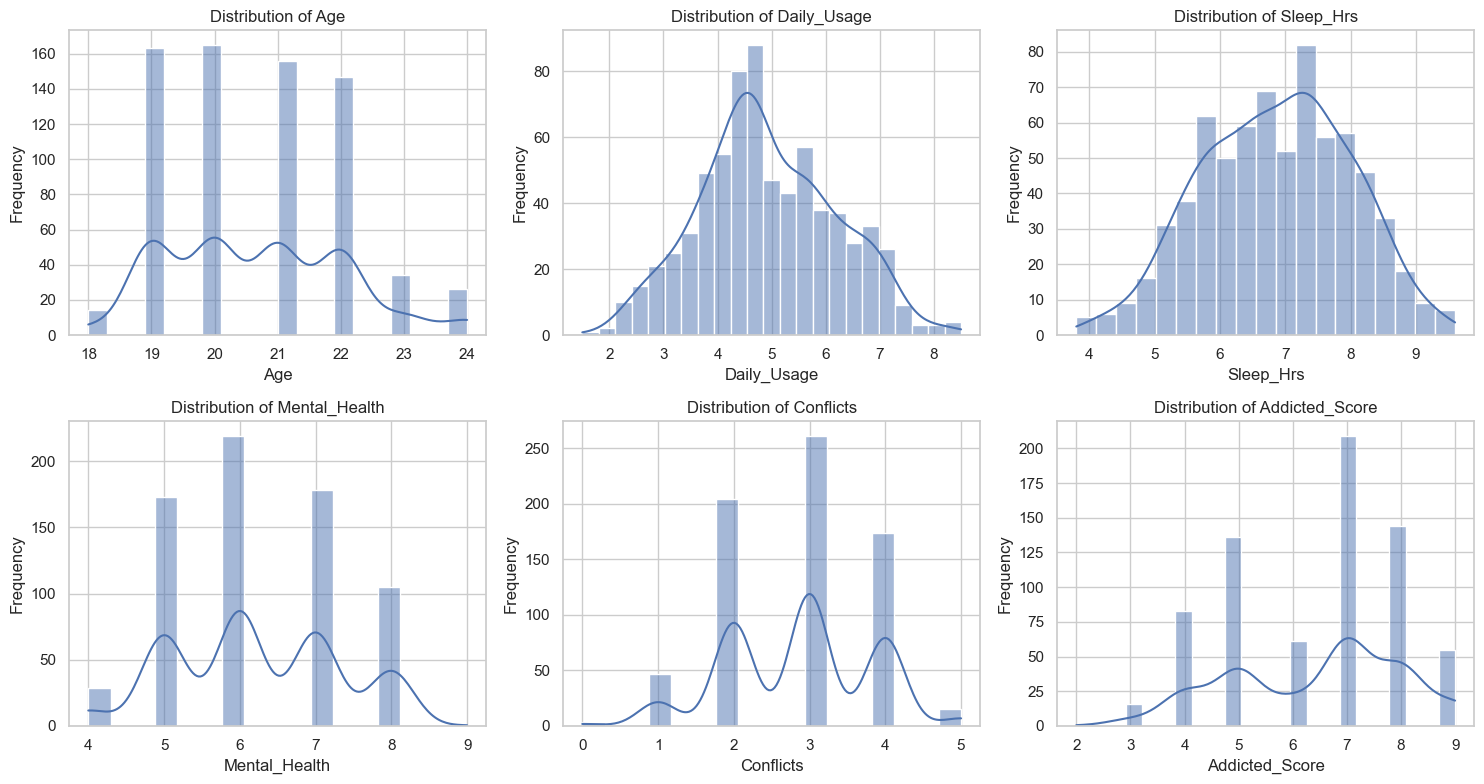

In [93]:
plot_distributions(df_data, num_cols, plot_type='histogram')


## Skewness calculation
- The skew function for 'Avg_Daily_Usage_Hours' and 'Sleep_Hours_Per_Night' is relatively close to 0, indicating that the distributions are close to normal.

In [94]:
from scipy.stats import skew
skew_cols = ['Daily_Usage', 'Sleep_Hrs']
for var in skew_cols:
    val = df_data[var].dropna()
    sk = skew(val)
    print(f"{var}: Skewness = {sk:.2f}")

Daily_Usage: Skewness = 0.16
Sleep_Hrs: Skewness = -0.11


## Countplots for categorical variables
- The data is balanced between the genders, males and females are almost equal.
- We also have almost equal number of undergraduates and graduates, but fewer high school students.
- The majority of the participants are from India, USA, and Canada. 
    - There are ~80 countries with only 1 participant.

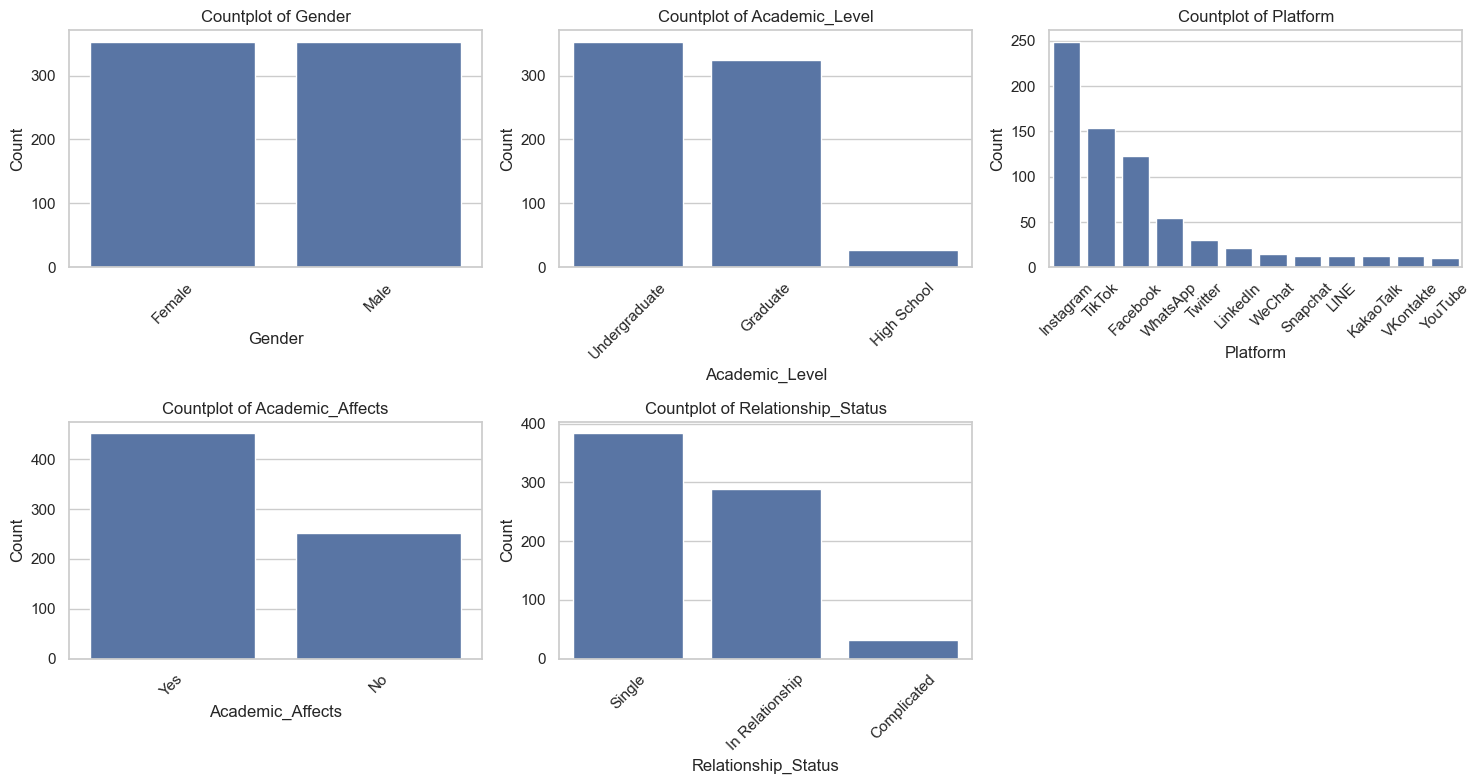

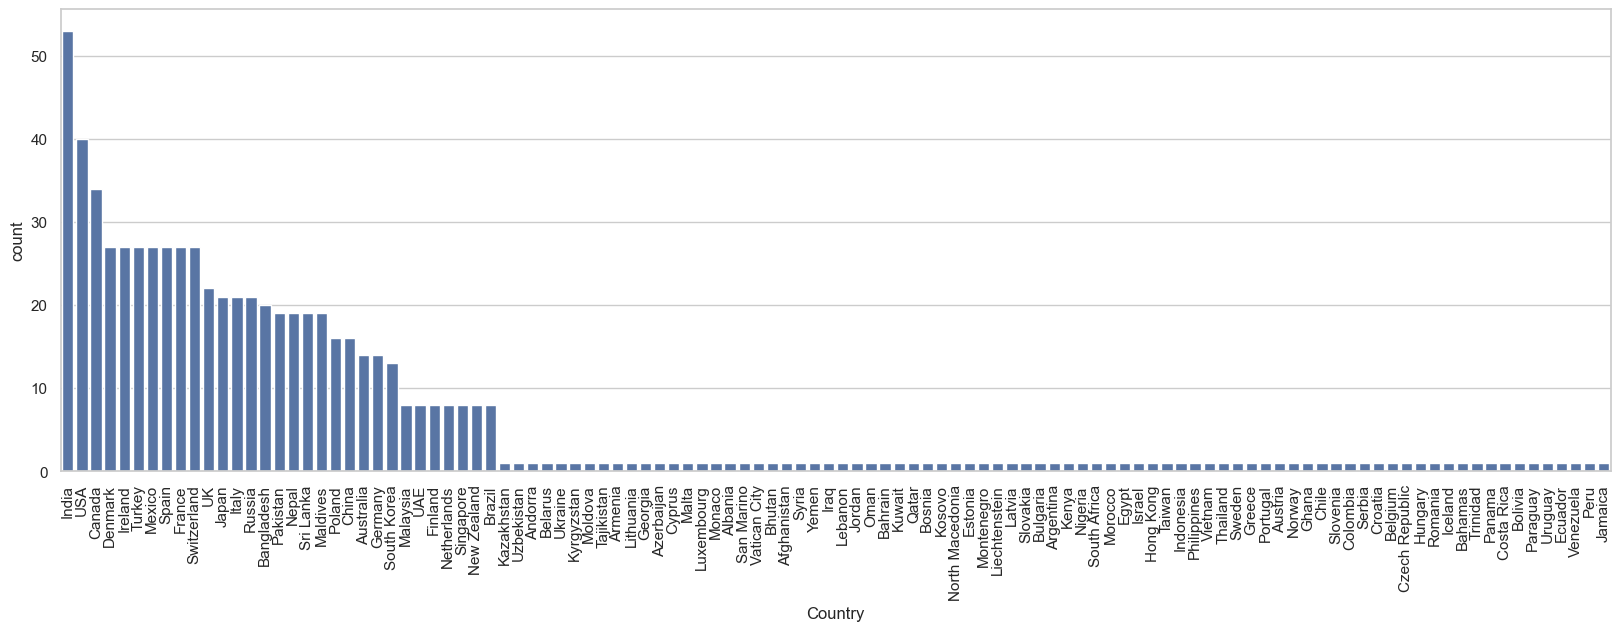

In [95]:
# countplots for categorical variables
count_plot_vars = cat_cols.copy()
count_plot_vars.remove('Country')
plot_distributions(df_data, count_plot_vars, plot_type='countplot')

# plot the countplot for the country
plt.figure(figsize=FIGSIZE_LONG)  # Set a wide figure size for better visualization

sns.countplot(data=df_data, x='Country', order=df_data['Country'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

In [96]:
print('number of countries with more than 1 participant: ', sum(df_data['Country'].value_counts()>1))
print('number of countries with only 1 participant: ', sum(df_data['Country'].value_counts()==1))

number of countries with more than 1 participant:  31
number of countries with only 1 participant:  79


# Outlier Detection

## Visual inspection using boxplots
- We use boxplots to inspect the outliers visually.
- In the boxplot, we can see that there are few outliers in the 'Avg_Daily_Usage_Hours'column.

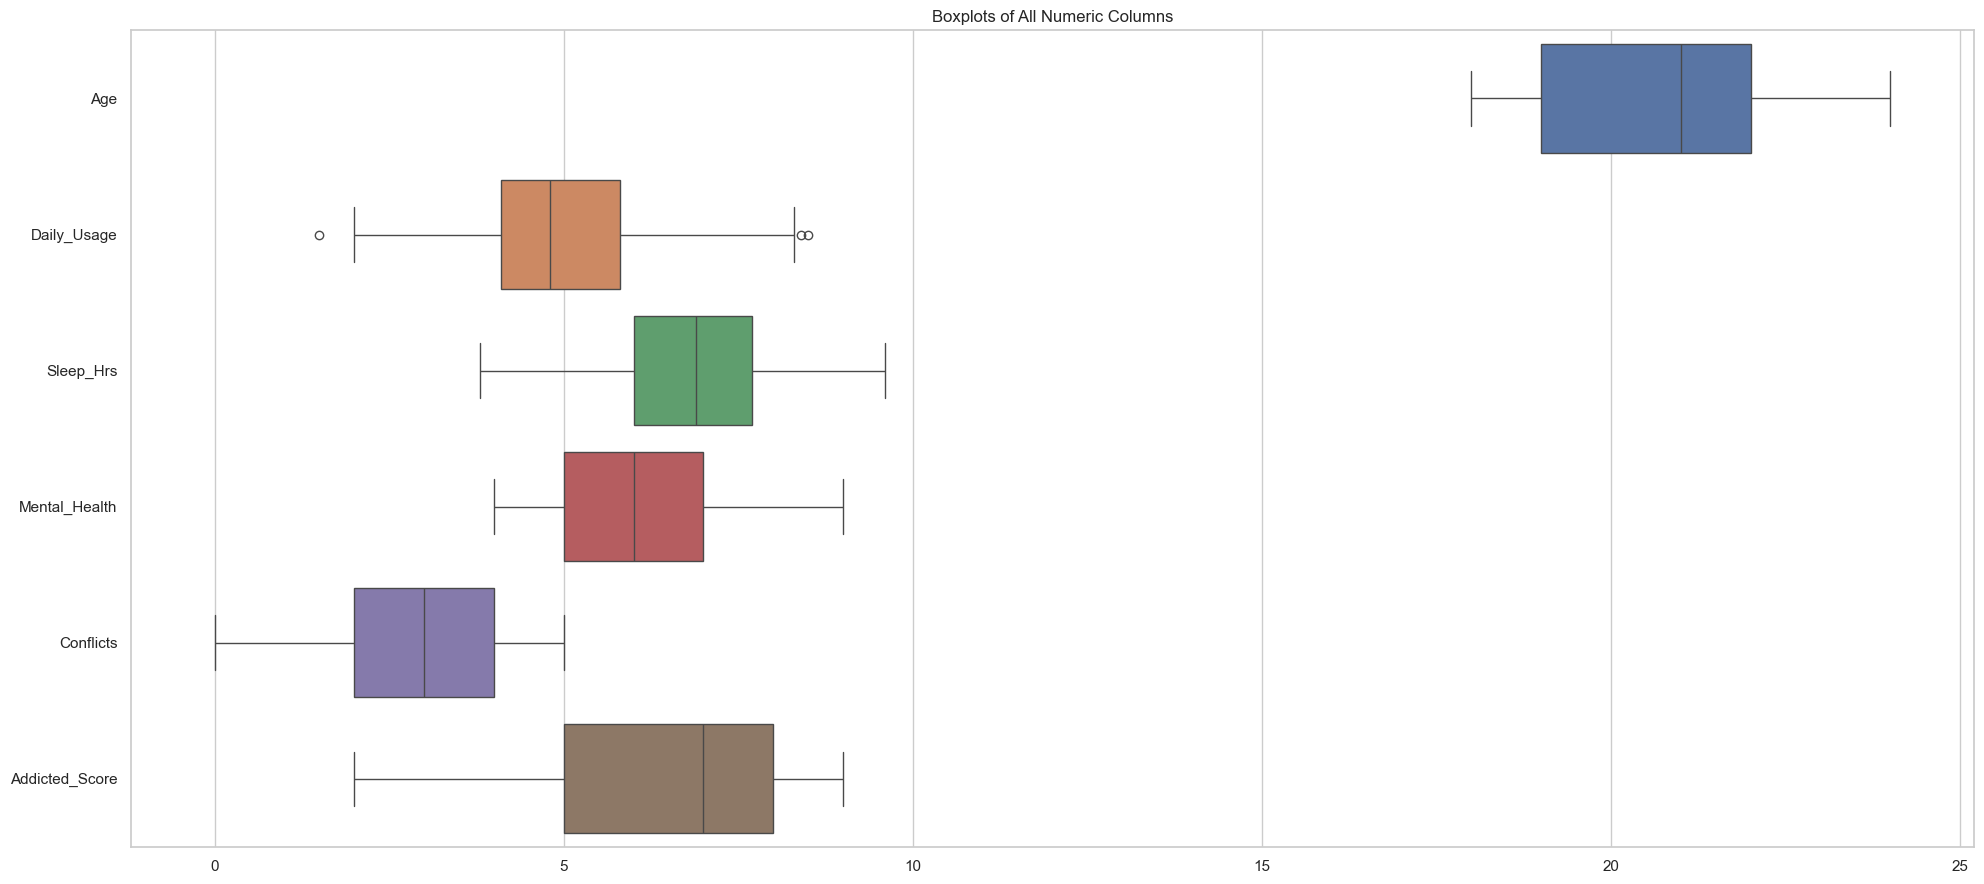

In [97]:

plt.figure(figsize=(20, len(num_cols) * 1.5))  # Dynamically adjust height
sns.boxplot(data=df_data[num_cols], orient='h')  # Horizontal boxplots for each column
plt.title('Boxplots of All Numeric Columns')
plt.tight_layout()
plt.show()

## Programmatic outlier inspection
- We use the IQR method to detect the outliers.
- The IQR method flags 3 potential outliers in the 'Avg_Daily_Usage_Hours' column.

In [98]:
def iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

for var in num_cols:
    count = iqr_outliers(df_data[var])
    print(f"{var}: {count} potential outliers")


Age: 0 potential outliers
Daily_Usage: 3 potential outliers
Sleep_Hrs: 0 potential outliers
Mental_Health: 0 potential outliers
Conflicts: 0 potential outliers
Addicted_Score: 0 potential outliers


# Correlation matrices for numerical features
- A strong positive correlation between 'Conflicts_Over_Social_Media' and 'Daily_Usage', 
- A strong negative correlation between 'Conflicts_Over_Social_Media' and 'Mental_Health'.
- A mederate negative correlation between 'Conflicts_Over_Social_Media' and 'Sleep_Hours'.

- Similar patterns are observed for 'Addicted_Score' and the input features.

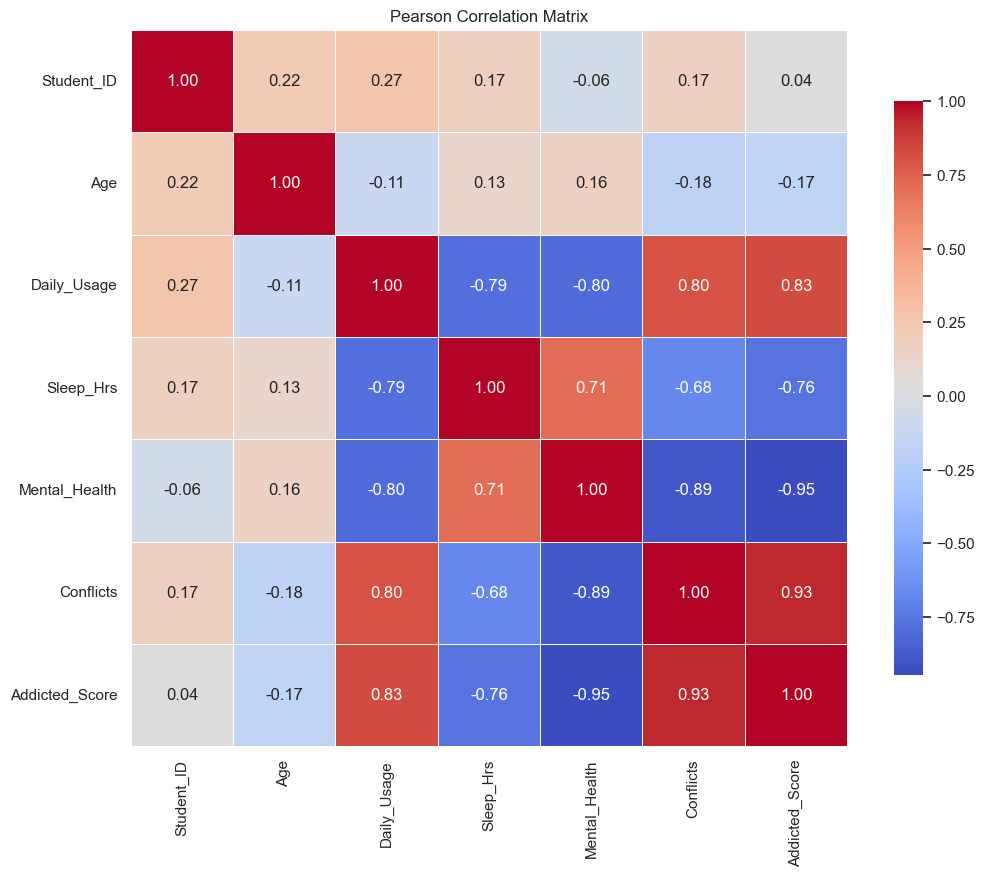

In [99]:
# Get numerical columns
numerical_cols = df_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

def plot_correlation_matrix(df_data, numerical_cols, method='pearson'):
    # Compute correlation matrix
    corr_pearson = df_data[numerical_cols].corr(method=method)
    corr_spearman = df_data[numerical_cols].corr(method=method)

    # Plot correlation heatmap
    plt.figure(figsize=(10, 8))
    # mask = np.triu(np.ones_like(corr_pearson, dtype=bool))
    sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm", 
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title(f'{method.capitalize()} Correlation Matrix')
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Plot Pearson correlation heatmap
plot_correlation_matrix(df_data, numerical_cols, method='pearson')




# Scatter Plots for Relationship Insights

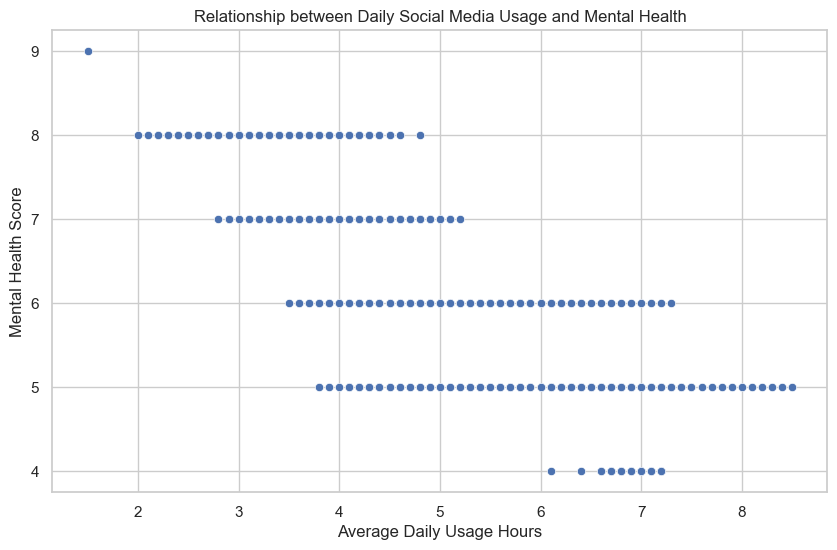

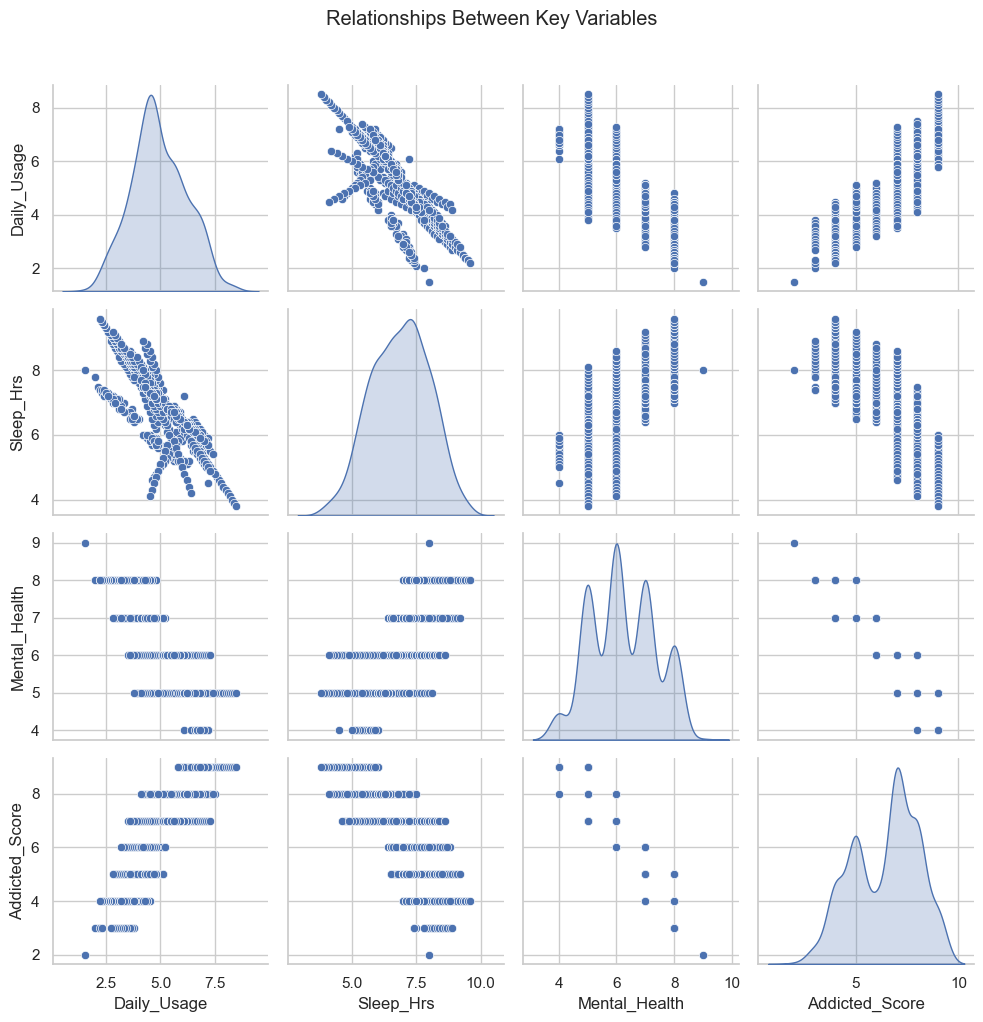

In [100]:
# Example: Usage Hours vs Mental Health Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_data, x='Daily_Usage', y='Mental_Health')
plt.title('Relationship between Daily Social Media Usage and Mental Health')
plt.xlabel('Average Daily Usage Hours')
plt.ylabel('Mental Health Score')
plt.show()

# Pairplot for selected features
selected_features = ['Daily_Usage', 'Sleep_Hrs', 
                     'Mental_Health', 'Addicted_Score']
sns.pairplot(df_data[selected_features], diag_kind='kde')
plt.suptitle('Relationships Between Key Variables', y=1.02)
plt.tight_layout()
plt.show()

 # Boxplots & Violin Plots

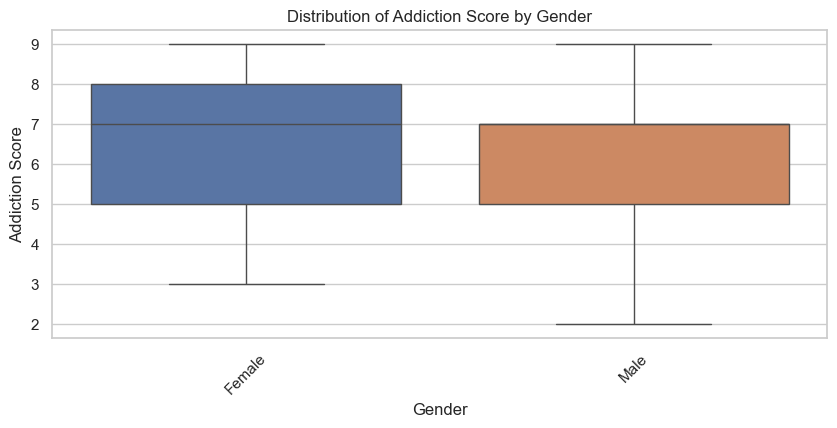

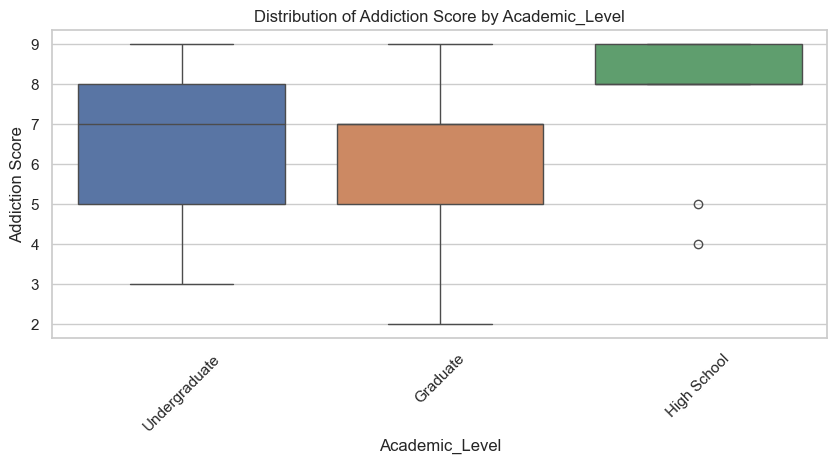

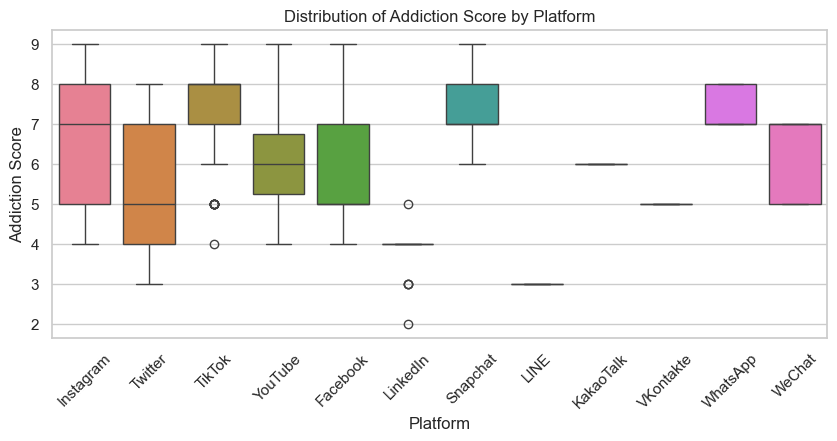

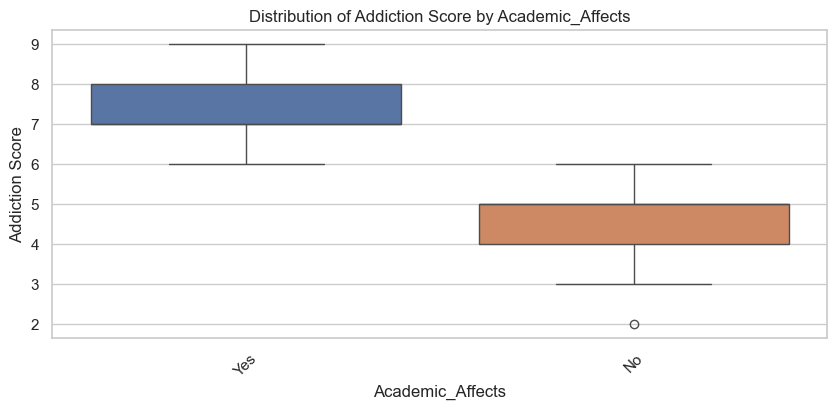

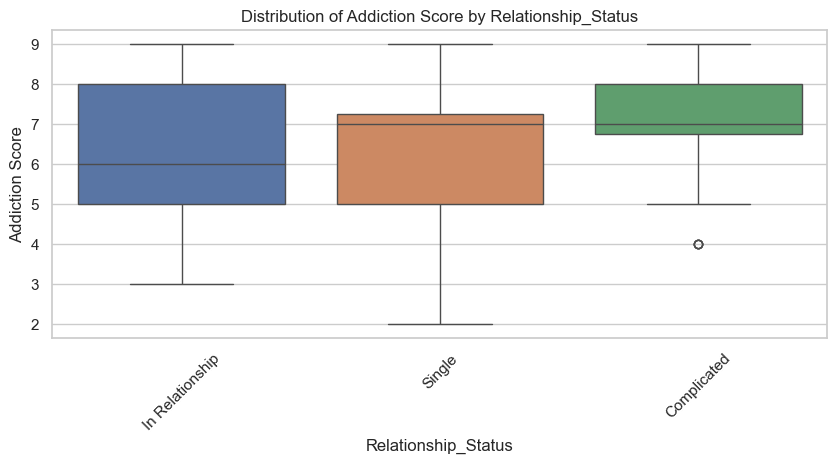

In [101]:
# Boxplot: Addicted_Score by Gender
boxplot_cols = cat_cols.copy()
boxplot_cols.remove('Country')
for col in boxplot_cols:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=df_data, x=col, y='Addicted_Score', hue=col)
    plt.title(f'Distribution of Addiction Score by {col}')
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.ylabel('Addiction Score')
    plt.show()

# Grouped Bar Plots

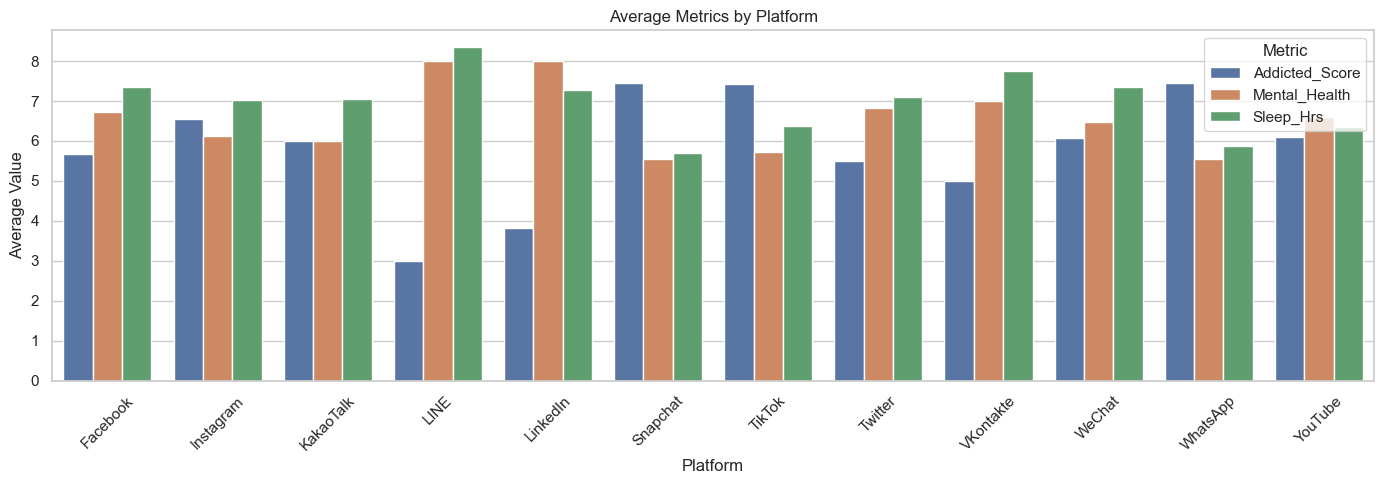

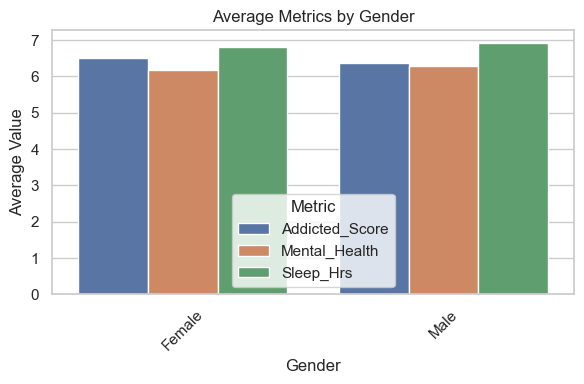

/var/folders/3b/p143t4hn1kzbzt8wz6ppzs9h0000gp/T/ipykernel_4616/699415994.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_avgs = df.groupby(category_col)[value_cols].mean().reset_index()


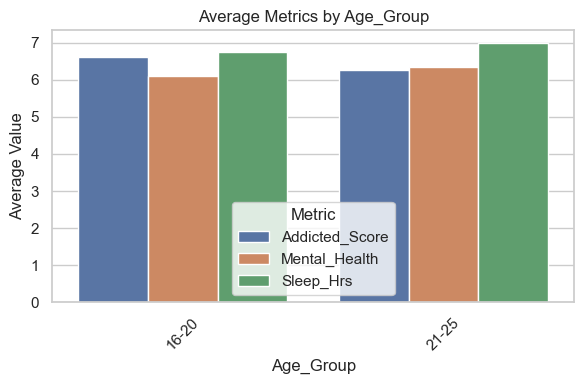

In [105]:
# Function to create grouped bar plots for average comparison
def plot_grouped_averages(df, category_col, value_cols, figsize = (14,5)):
    """
    Create grouped bar plots to compare averages across categories
    
    Parameters:
    - df: DataFrame containing the data
    - category_col: Column name for categories (x-axis)
    - value_cols: List of column names for values to compare
    """
    # Calculate group averages
    group_avgs = df.groupby(category_col)[value_cols].mean().reset_index()
    
    # Reshape data for plotting
    melted_df = pd.melt(group_avgs, id_vars=[category_col], 
                        value_vars=value_cols,
                        var_name='Metric', value_name='Average Value')
    
    # Create the grouped bar plot
    plt.figure(figsize=figsize)
    sns.barplot(data=melted_df, x=category_col, y='Average Value', hue='Metric')
    plt.title(f'Average Metrics by {category_col}')
    plt.xlabel(category_col)
    plt.ylabel('Average Value')
    plt.xticks(rotation=45)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

# Example usage
value_columns = ['Addicted_Score', 'Mental_Health', 'Sleep_Hrs']

# By platform
plot_grouped_averages(df_data, 'Platform', value_columns)

# By gender
plot_grouped_averages(df_data, 'Gender', value_columns, (6,4))

# By age group (create age groups first)
df_data['Age_Group'] = pd.cut(df_data['Age'], bins=[15, 20, 25], labels=['16-20', '21-25'])
plot_grouped_averages(df_data, 'Age_Group', value_columns, (6,4))

# Target-aware Exploration

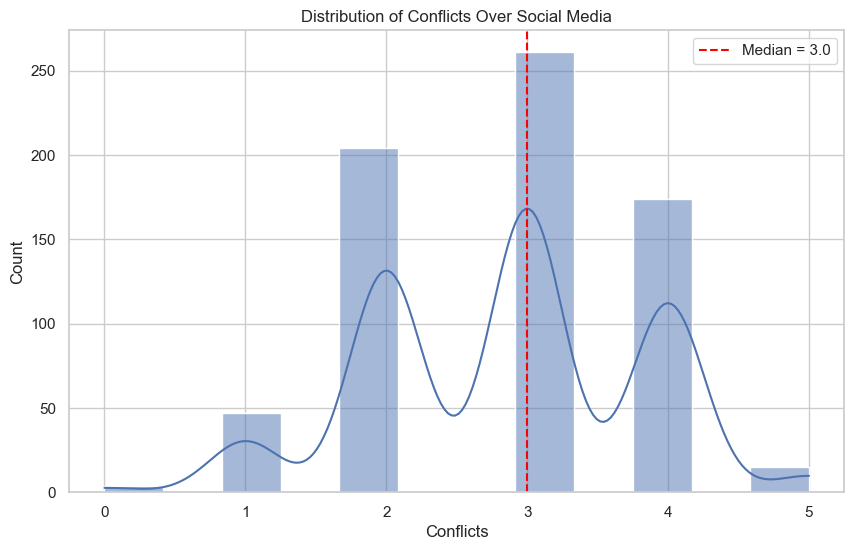

Binary Conflict Distribution:
Conflict_Binary
Low     516
High    189
Name: count, dtype: int64
Class imbalance ratio: 2.73


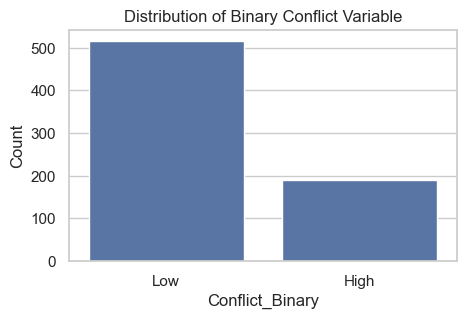

In [106]:
# 1. Convert Conflicts_Over_Social_Media into binary categories
# First, let's examine the distribution to determine a meaningful threshold
plt.figure(figsize=(10, 6))
sns.histplot(df_data['Conflicts'], kde=True)
plt.axvline(df_data['Conflicts'].median(), color='red', linestyle='--', 
           label=f'Median = {df_data["Conflicts"].median()}')
plt.title('Distribution of Conflicts Over Social Media')
plt.legend()
plt.show()

# Create binary target variable based on median split
median_conflict = df_data['Conflicts'].median()
df_data['Conflict_Binary'] = df_data['Conflicts'].apply(
    lambda x: 'High' if x > median_conflict else 'Low'
)

# Check the distribution of the binary variable
conflict_counts = df_data['Conflict_Binary'].value_counts()
print("Binary Conflict Distribution:")
print(conflict_counts)
print(f"Class imbalance ratio: {conflict_counts.max() / conflict_counts.min():.2f}")

# Visualize the binary distribution
plt.figure(figsize=(5, 3))
sns.countplot(data=df_data, x='Conflict_Binary')
plt.title('Distribution of Binary Conflict Variable')
plt.ylabel('Count')
plt.show()

/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 67.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 72.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


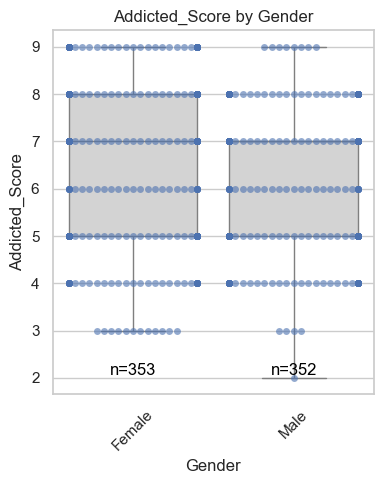

/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 78.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 77.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


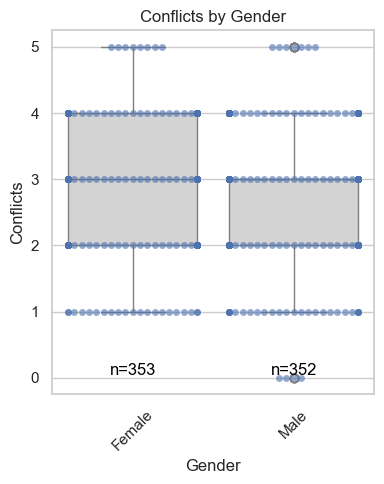

/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 73.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


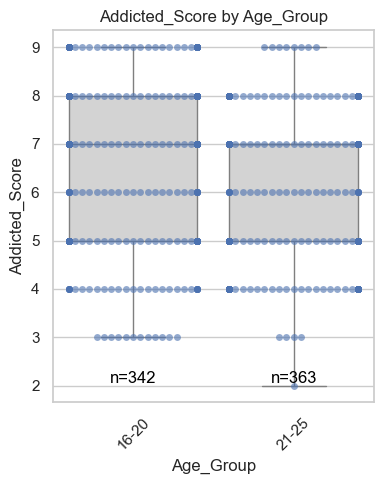

/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 78.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 78.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


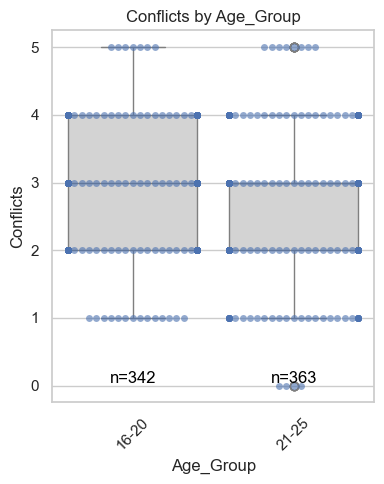

/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 76.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 79.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


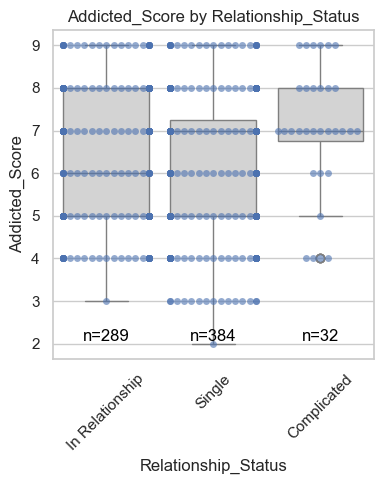

/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 84.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 84.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


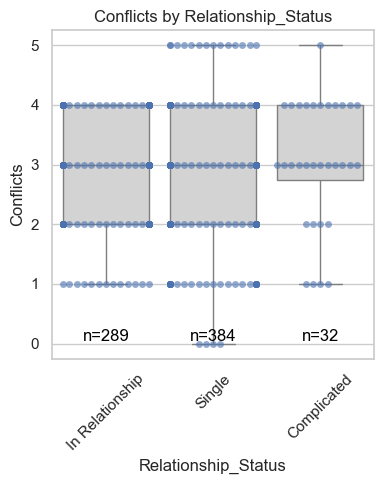

/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 83.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 76.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 69.1% of the points cannot be placed; you may want to decrease the size of the mark

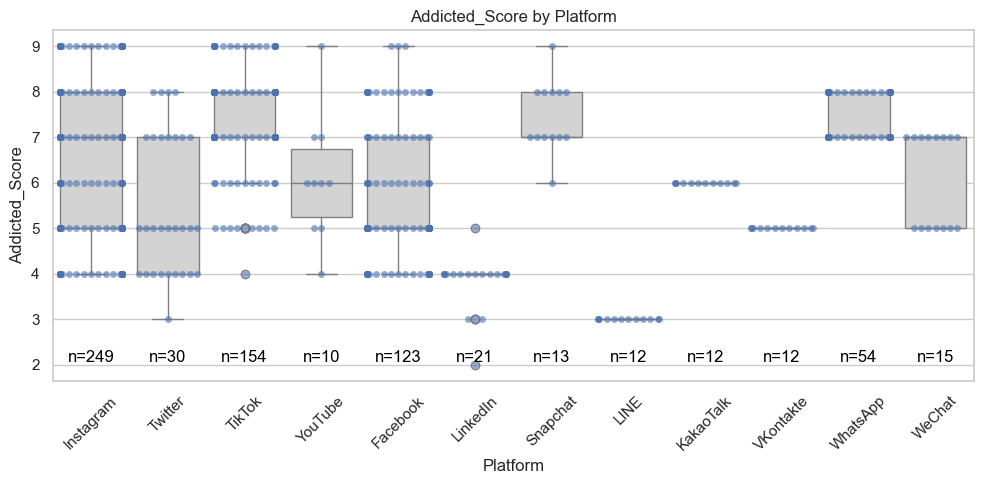

/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 85.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 36.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 83.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/.c29env/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 74.8% of the points cannot be placed; you may want to decrease the size of the mark

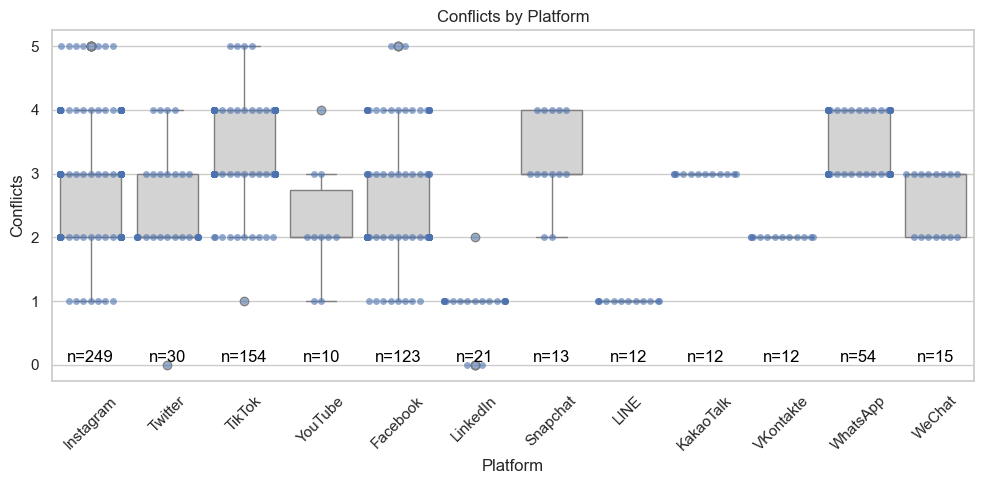

In [119]:
# 2. Plot addiction/conflict metrics against demographics or behaviors

# Function to create swarm plots with overlaid box plots
def plot_target_by_category(df, target_col, category_col, title=None, figsize=(4, 5)):
    plt.figure(figsize=figsize)
    # Create a swarm plot with box plot overlay
    ax = sns.boxplot(data=df, x=category_col, y=target_col, color='lightgray')
    sns.swarmplot(data=df, x=category_col, y=target_col, alpha=0.6)
    
    # Set title and labels
    plt.title(title or f'{target_col} by {category_col}')
    plt.xlabel(category_col)
    plt.ylabel(target_col)
    plt.xticks(rotation=45)
    
    # Add sample size annotations
    for i, category in enumerate(df[category_col].unique()):
        count = df[df[category_col] == category].shape[0]
        ax.text(i, df[target_col].min(), f'n={count}', ha='center', va='bottom', color='black')
    
    plt.tight_layout()
    plt.show()

# Example usages for demographic variables
demographic_vars = ['Gender', 'Age_Group']
for var in demographic_vars:
    plot_target_by_category(df_data, 'Addicted_Score', var)
    plot_target_by_category(df_data, 'Conflicts', var)

# Example usages for behavioral variables
var = 'Relationship_Status'
plot_target_by_category(df_data, 'Addicted_Score', var)
plot_target_by_category(df_data, 'Conflicts', var)

var = 'Platform'
figsize = (10, 5)
plot_target_by_category(df_data, 'Addicted_Score', var, figsize=figsize)
plot_target_by_category(df_data, 'Conflicts', var, figsize=figsize)



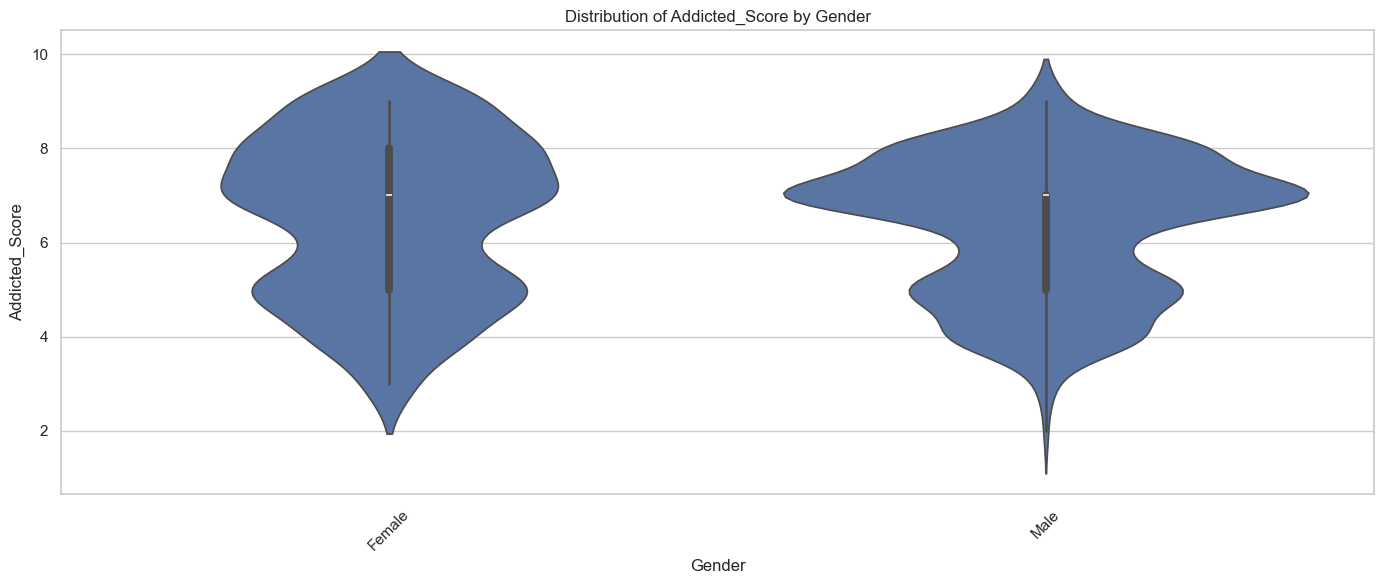

ValueError: Could not interpret value `Conflicts_Over_Social_Media` for `y`. An entry with this name does not appear in `data`.

<Figure size 1400x600 with 0 Axes>

In [120]:
# 3. Create violin plots for visual comparisons
def plot_violin_by_category(df, target_col, category_col, title=None):
    plt.figure(figsize=(14, 6))
    sns.violinplot(data=df, x=category_col, y=target_col, inner='box')
    
    # Set title and labels
    plt.title(title or f'Distribution of {target_col} by {category_col}')
    plt.xlabel(category_col)
    plt.ylabel(target_col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usages for key variables
key_categories = ['Gender', 'Most_Used_Platform', 'Relationship_Status']
for cat in key_categories:
    plot_violin_by_category(df_data, 'Addicted_Score', cat)
    plot_violin_by_category(df_data, 'Conflicts', cat)